In [1]:
from seances.models import Seance
print("Number of completed seances:")
print(Seance.objects.filter(valid=True).count())
    
print("Experiment 1 count: {}".format(Seance.objects.filter(experiment__sequence_number=1).count()))
print("Experiment 2 count: {}".format(Seance.objects.filter(experiment__sequence_number=2).count()))
print("Experiment 3 count: {}".format(Seance.objects.filter(experiment__sequence_number=3).count()))


Number of completed seances:
125
Experiment 1 count: 42
Experiment 2 count: 42
Experiment 3 count: 41


In [2]:
# Loading the data from the db
# should we use Influx and interpolated data (probably not)?
# it will take some time to calculate all features for everyone.

from numpy import mean, std
from sklearn.preprocessing import normalize

def load_data(username, seance_num, sens):
    try:
        seance = Seance.objects.filter(user__username=username, valid=True).order_by('created')[seance_num]
    except IndexError:
        print("Invalid seance id.")
        return
    if sens == "accelerometer":
        sensor_ids = [60,61,62]
        sensors = Sensor.objects.filter(id__in=sensor_ids).order_by('id')
        return (
                SensorRecord.objects.filter(seance=seance, sensor=sensors[0]).order_by("created"), 
                SensorRecord.objects.filter(seance=seance, sensor=sensors[1]).order_by("created"), 
                SensorRecord.objects.filter(seance=seance, sensor=sensors[2]).order_by("created")
        )
    elif sens == "gyroscope":
        sensor_ids = [63,64,65]
        sensors = Sensor.objects.filter(id__in=sensor_ids).order_by('id')
        return (
                SensorRecord.objects.filter(seance=seance, sensor=sensors[0]).order_by("created"), 
                SensorRecord.objects.filter(seance=seance, sensor=sensors[1]).order_by("created"), 
                SensorRecord.objects.filter(seance=seance, sensor=sensors[2]).order_by("created")
        )
    elif sens == "force":
        sensor_ids = [54,55,76,77]
        sensors = Sensor.objects.filter(id__in=sensor_ids).order_by('topic')
        return (
                SensorRecord.objects.filter(seance=seance, sensor=sensors[0], value__gte=50).order_by("created"), 
                SensorRecord.objects.filter(seance=seance, sensor=sensors[1], value__gte=50).order_by("created"), 
                SensorRecord.objects.filter(seance=seance, sensor=sensors[2], value__gte=50).order_by("created"), 
                SensorRecord.objects.filter(seance=seance, sensor=sensors[3], value__gte=50).order_by("created")
        )
    elif sens == "cpu":
        sensor_ids = [78,79,80,81]
        sensors = Sensor.objects.filter(id__in=sensor_ids).order_by('topic')
        return (
                SensorRecord.objects.filter(seance=seance, sensor=sensors[0]).order_by("created"), 
                SensorRecord.objects.filter(seance=seance, sensor=sensors[1]).order_by("created"), 
                SensorRecord.objects.filter(seance=seance, sensor=sensors[2]).order_by("created"), 
                SensorRecord.objects.filter(seance=seance, sensor=sensors[3]).order_by("created")
        )
    elif sens == "ram":
        sensor_ids = [82]
        sensors = Sensor.objects.filter(id__in=sensor_ids).order_by('topic')
        return SensorRecord.objects.filter(seance=seance, sensor=sensors[0]).order_by("created")
    elif sens == "net":
        sensor_ids = [83, 84]
        sensors = Sensor.objects.filter(id__in=sensor_ids).order_by('id')
        return (
            SensorRecord.objects.filter(seance=seance, sensor=sensors[0]).order_by("created"),
            SensorRecord.objects.filter(seance=seance, sensor=sensors[1]).order_by("created")
        )
    elif sens == "pir":
        sensor_ids = [58, 59, 66, 67, 68, 69]
        sensors = Sensor.objects.filter(id__in=sensor_ids).order_by('id')
        return (
            SensorRecord.objects.filter(seance=seance, sensor__in=sensors).order_by("created"),
            seance.start,
            seance.end,
        )
    else:
        raise ValueError("Invalid sensor string.")
    

### Variables naming conventions
This is done to preserve as many data as possible in ram, which reduces load times on multiple runs.

sensorType_userNumber_featureName_axis_experiment

- axis is only applicable with accelerometer, gyroscope and force sensors
- experiment is only applicable if we have multiple experiments for the same person

example:

acc_1_val_x_2

In [ ]:
# Functions
from scipy.signal import find_peaks
from datetime import datetime, timedelta
from math import sqrt
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import plotly.express as px
from plotly.express import line
from pandas import DataFrame
from numpy import mean, std
import plotly.graph_objects as go


def process_signal(records):
    """
    Take Django query and do basic signal processing.
    """
    values = [x.value for x in records]
    times = [x.timestamp for x in records]
    m = mean(values)
    s = std(values)
    norm = [(x - m)/s for x in values]
    
    return values, times, norm, m, s

def process_binary_signal(records):
    """
    Take Django query with hall or pir data and return meaningful statistics.
    """
    if len(records) == 0:
        return [], []
    values = [x.value for x in records]
    times = [x.timestamp for x in records]
    ids = [x.sensor_id for x in records]
    return values, times, ids
    
def mean_crossing_rate(signal, m):
    """
    Calculate mean crossing rate from signal.
    Rate of mean crossings vs. the signal length.
    """
    prev = signal[0]
    crosses = 0
    length = len(signal) - 1
    
    for curr in signal[1:]:
        if prev <= m < curr or prev > m >=curr:
            crosses += 1
        prev = curr
    return crosses/length

def mean_acceleration_intensity(signal):
    """
    Mean derivative of a signal.
    """
    prev = signal[0]
    length = len(signal) - 1
    derv = []
    
    for curr in signal[1:]:
        derv.append(abs(curr - prev))
        prev = curr
        
    return mean(derv)
    

def create_time_chunks(start: datetime, end: datetime, interval: timedelta):
    """
    Create a list of time intervals for given parameters.
    """
    intervals = []
    while start < end:
        intervals.append((start, min(start + interval, end)))
        start += interval
    return intervals


def join_accelerometer_signals(x, y, z):
    """
    Join accelerometer signals, based simply on concurrence. 
    We can do this, as only one controller sends data in loop for all axis.
    """
    result = []
    n = min(len(x), len(y), len(z))
    for a,b,c in zip(x[:n], y[:n], z[:n]):
        result.append(sqrt(a**2+b**2+c**2))
    return result, mean(result), std(result)


def join_cpu_signals(a, b, c, d):
    """
    Similar to accelerometer one.
    """
    result = []
    n = min(len(a), len(b), len(c), len(d))
    for w,x,y,z in zip(a[:n], b[:n], c[:n], d[:n]):
        result.append(sqrt(w**2+x**2+y**2+z**2))
    return result, mean(result), std(result)
    
    

# Accelerometer data overview

In [ ]:
users = ["test_subject_10", "test_subject_11", "test_subject_12", "test_subject_13"]

accx11, accy11, accz11 = load_data(users[0], 0, "accelerometer")
accx12, accy12, accz12 = load_data(users[0], 3, "accelerometer")
accx21, accy21, accz21 = load_data(users[1], 0, "accelerometer")
accx22, accy22, accz22 = load_data(users[1], 3, "accelerometer")
accx31, accy31, accz31 = load_data(users[2], 0, "accelerometer")
accx32, accy32, accz32 = load_data(users[2], 3, "accelerometer")
accx41, accy41, accz41 = load_data(users[3], 0, "accelerometer")
accx42, accy42, accz42 = load_data(users[3], 3, "accelerometer")

acc_1_val_x_1, _, acc_1_nor_x_1, acc_1_mea_x_1, acc_1_std_x_1 = process_signal(accx11)
acc_1_val_y_1, _, acc_1_nor_y_1, acc_1_mea_y_1, acc_1_std_y_1 = process_signal(accy11)
acc_1_val_z_1, _, acc_1_nor_z_1, acc_1_mea_z_1, acc_1_std_z_1 = process_signal(accz11)
acc_1_val_x_2, _, acc_1_nor_x_2, acc_1_mea_x_2, acc_1_std_x_2 = process_signal(accx12)
acc_1_val_y_2, _, acc_1_nor_y_2, acc_1_mea_y_2, acc_1_std_y_2 = process_signal(accy12)
acc_1_val_z_2, _, acc_1_nor_z_2, acc_1_mea_z_2, acc_1_std_z_2 = process_signal(accz12)
acc_1_nor_1, acc_1_mea_1, acc_1_std_1 = join_accelerometer_signals(acc_1_nor_x_1, acc_1_nor_y_1, acc_1_nor_z_1)
acc_1_nor_2, acc_1_mea_2, acc_1_std_2 = join_accelerometer_signals(acc_1_nor_x_2, acc_1_nor_y_2, acc_1_nor_z_2)

acc_2_val_x_1, _, acc_2_nor_x_1, acc_2_mea_x_1, acc_2_std_x_1 = process_signal(accx21)
acc_2_val_y_1, _, acc_2_nor_y_1, acc_2_mea_y_1, acc_2_std_y_1 = process_signal(accy21)
acc_2_val_z_1, _, acc_2_nor_z_1, acc_2_mea_z_1, acc_2_std_z_1 = process_signal(accz21)
acc_2_val_x_2, _, acc_2_nor_x_2, acc_2_mea_x_2, acc_2_std_x_2 = process_signal(accx22)
acc_2_val_y_2, _, acc_2_nor_y_2, acc_2_mea_y_2, acc_2_std_y_2 = process_signal(accy22)
acc_2_val_z_2, _, acc_2_nor_z_2, acc_2_mea_z_2, acc_2_std_z_2 = process_signal(accz22)
acc_2_nor_1, acc_2_mea_1, acc_2_std_1 = join_accelerometer_signals(acc_2_nor_x_1, acc_2_nor_y_1, acc_2_nor_z_1)
acc_2_nor_2, acc_2_mea_2, acc_2_std_2 = join_accelerometer_signals(acc_2_nor_x_2, acc_2_nor_y_2, acc_2_nor_z_2)

acc_3_val_x_1, _, acc_3_nor_x_1, acc_3_mea_x_1, acc_3_std_x_1 = process_signal(accx31)
acc_3_val_y_1, _, acc_3_nor_y_1, acc_3_mea_y_1, acc_3_std_y_1 = process_signal(accy31)
acc_3_val_z_1, _, acc_3_nor_z_1, acc_3_mea_z_1, acc_3_std_z_1 = process_signal(accz31)
acc_3_val_x_2, _, acc_3_nor_x_2, acc_3_mea_x_2, acc_3_std_x_2 = process_signal(accx32)
acc_3_val_y_2, _, acc_3_nor_y_2, acc_3_mea_y_2, acc_3_std_y_2 = process_signal(accy32)
acc_3_val_z_2, _, acc_3_nor_z_2, acc_3_mea_z_2, acc_3_std_z_2 = process_signal(accz32)
acc_3_nor_1, acc_3_mea_1, acc_3_std_1 = join_accelerometer_signals(acc_3_nor_x_1, acc_3_nor_y_1, acc_3_nor_z_1)
acc_3_nor_2, acc_3_mea_2, acc_3_std_2 = join_accelerometer_signals(acc_3_nor_x_2, acc_3_nor_y_2, acc_3_nor_z_2)

acc_4_val_x_1, _, acc_4_nor_x_1, acc_4_mea_x_1, acc_4_std_x_1 = process_signal(accx41)
acc_4_val_y_1, _, acc_4_nor_y_1, acc_4_mea_y_1, acc_4_std_y_1 = process_signal(accy41)
acc_4_val_z_1, _, acc_4_nor_z_1, acc_4_mea_z_1, acc_4_std_z_1 = process_signal(accz41)
acc_4_val_x_2, _, acc_4_nor_x_2, acc_4_mea_x_2, acc_4_std_x_2 = process_signal(accx42)
acc_4_val_y_2, _, acc_4_nor_y_2, acc_4_mea_y_2, acc_4_std_y_2 = process_signal(accy42)
acc_4_val_z_2, _, acc_4_nor_z_2, acc_4_mea_z_2, acc_4_std_z_2 = process_signal(accz42)
acc_4_nor_1, acc_4_mea_1, acc_4_std_1 = join_accelerometer_signals(acc_4_nor_x_1, acc_4_nor_y_1, acc_4_nor_z_1)
acc_4_nor_2, acc_4_mea_2, acc_4_std_2 = join_accelerometer_signals(acc_4_nor_x_2, acc_4_nor_y_2, acc_4_nor_z_2)

## Visualization

In [ ]:
stats = DataFrame(acc_1_nor_1, columns=["values"])
fig = px.line(stats, y="values")
fig.show()

## Mean values

In [ ]:
print("X mean values:")
print(acc_1_mea_x_1)
print(acc_1_mea_x_2)
print(acc_2_mea_x_1)
print(acc_2_mea_x_2)
print(acc_3_mea_x_1)
print(acc_3_mea_x_2)
print(acc_4_mea_x_1)
print(acc_4_mea_x_2)
print()
print("Y mean values:")
print(acc_1_mea_y_1)
print(acc_1_mea_y_2)
print(acc_2_mea_y_1)
print(acc_2_mea_y_2)
print(acc_3_mea_y_1)
print(acc_3_mea_y_2)
print(acc_4_mea_y_1)
print(acc_4_mea_y_2)
print()
print("Z mean values:")
print(acc_1_mea_z_1)
print(acc_1_mea_z_2)
print(acc_2_mea_z_1)
print(acc_2_mea_z_2)
print(acc_3_mea_z_1)
print(acc_3_mea_z_2)
print(acc_4_mea_z_1)
print(acc_4_mea_z_2)
print()
print("Combined mean values:")
print(acc_1_mea_1)
print(acc_1_mea_2)
print(acc_2_mea_1)
print(acc_2_mea_2)
print(acc_3_mea_1)
print(acc_3_mea_2)
print(acc_4_mea_1)
print(acc_4_mea_2)

## Standard deviations

In [ ]:
print("X stdn values:")
print(acc_1_std_x_1)
print(acc_1_std_x_2)
print(acc_2_std_x_1)
print(acc_2_std_x_2)
print(acc_3_std_x_1)
print(acc_3_std_x_2)
print(acc_4_std_x_1)
print(acc_4_std_x_2)
print()
print("Y stdn values:")
print(acc_1_std_y_1)
print(acc_1_std_y_2)
print(acc_2_std_y_1)
print(acc_2_std_y_2)
print(acc_3_std_y_1)
print(acc_3_std_y_2)
print(acc_4_std_y_1)
print(acc_4_std_y_2)
print()
print("Z stdn values:")
print(acc_1_std_z_1)
print(acc_1_std_z_2)
print(acc_2_std_z_1)
print(acc_2_std_z_2)
print(acc_3_std_z_1)
print(acc_3_std_z_2)
print(acc_4_std_z_1)
print(acc_4_std_z_2)
print()
print("Combined stdn values:")
print(acc_1_std_1)
print(acc_1_std_2)
print(acc_2_std_1)
print(acc_2_std_2)
print(acc_3_std_1)
print(acc_3_std_2)
print(acc_4_std_1)
print(acc_4_std_2)

## Mean crossing rate
- use time warping on values?

In [ ]:
print("X mean crossing rate:")
print(mean_crossing_rate(acc_1_val_x_1, acc_1_mea_x_1))
print(mean_crossing_rate(acc_1_val_x_2, acc_1_mea_x_2))
print(mean_crossing_rate(acc_2_val_x_1, acc_2_mea_x_1))
print(mean_crossing_rate(acc_2_val_x_2, acc_2_mea_x_2))
print(mean_crossing_rate(acc_3_val_x_1, acc_3_mea_x_1))
print(mean_crossing_rate(acc_3_val_x_2, acc_3_mea_x_2))
print(mean_crossing_rate(acc_4_val_x_1, acc_4_mea_x_1))
print(mean_crossing_rate(acc_4_val_x_2, acc_4_mea_x_2))
print()
print("Y mean crossing rate:")
print(mean_crossing_rate(acc_1_val_y_1, acc_1_mea_y_1))
print(mean_crossing_rate(acc_1_val_y_2, acc_1_mea_y_2))
print(mean_crossing_rate(acc_2_val_y_1, acc_2_mea_y_1))
print(mean_crossing_rate(acc_2_val_y_2, acc_2_mea_y_2))
print(mean_crossing_rate(acc_3_val_y_1, acc_3_mea_y_1))
print(mean_crossing_rate(acc_3_val_y_2, acc_3_mea_y_2))
print(mean_crossing_rate(acc_4_val_y_1, acc_4_mea_y_1))
print(mean_crossing_rate(acc_4_val_y_2, acc_4_mea_y_2))
print()
print("Z mean crossing rate:")
print(mean_crossing_rate(acc_1_val_z_1, acc_1_mea_z_1))
print(mean_crossing_rate(acc_1_val_z_2, acc_1_mea_z_2))
print(mean_crossing_rate(acc_2_val_z_1, acc_2_mea_z_1))
print(mean_crossing_rate(acc_2_val_z_2, acc_2_mea_z_2))
print(mean_crossing_rate(acc_3_val_z_1, acc_3_mea_z_1))
print(mean_crossing_rate(acc_3_val_z_2, acc_3_mea_z_2))
print(mean_crossing_rate(acc_4_val_z_1, acc_4_mea_z_1))
print(mean_crossing_rate(acc_4_val_z_2, acc_4_mea_z_2))
print()
print("Combined crossing rate:")
print(mean_crossing_rate(acc_1_nor_1, acc_1_mea_1))
print(mean_crossing_rate(acc_1_nor_2, acc_1_mea_2))
print(mean_crossing_rate(acc_2_nor_1, acc_2_mea_1))
print(mean_crossing_rate(acc_2_nor_2, acc_2_mea_2))
print(mean_crossing_rate(acc_3_nor_1, acc_3_mea_1))
print(mean_crossing_rate(acc_3_nor_2, acc_3_mea_2))
print(mean_crossing_rate(acc_4_nor_1, acc_4_mea_1))
print(mean_crossing_rate(acc_4_nor_2, acc_4_mea_2))

## Mean acceleration intensity
- Calculated by taking the mean derivative of a signal.

In [ ]:
print("X mean acceleration intensity:")
print(mean_acceleration_intensity(acc_1_val_x_1))
print(mean_acceleration_intensity(acc_1_val_x_2))
print(mean_acceleration_intensity(acc_2_val_x_1))
print(mean_acceleration_intensity(acc_2_val_x_2))
print(mean_acceleration_intensity(acc_3_val_x_1))
print(mean_acceleration_intensity(acc_3_val_x_2))
print(mean_acceleration_intensity(acc_4_val_x_1))
print(mean_acceleration_intensity(acc_4_val_x_2))
print()
print("Y mean acceleration intensity:")
print(mean_acceleration_intensity(acc_1_val_y_1))
print(mean_acceleration_intensity(acc_1_val_y_2))
print(mean_acceleration_intensity(acc_2_val_y_1))
print(mean_acceleration_intensity(acc_2_val_y_2))
print(mean_acceleration_intensity(acc_3_val_y_1))
print(mean_acceleration_intensity(acc_3_val_y_2))
print(mean_acceleration_intensity(acc_4_val_y_1))
print(mean_acceleration_intensity(acc_4_val_y_2))
print()
print("Z mean acceleration intensity:")
print(mean_acceleration_intensity(acc_1_val_z_1))
print(mean_acceleration_intensity(acc_1_val_z_2))
print(mean_acceleration_intensity(acc_2_val_z_1))
print(mean_acceleration_intensity(acc_2_val_z_2))
print(mean_acceleration_intensity(acc_3_val_z_1))
print(mean_acceleration_intensity(acc_3_val_z_2))
print(mean_acceleration_intensity(acc_4_val_z_1))
print(mean_acceleration_intensity(acc_4_val_z_2))
print()
print("Combined acceleration intensity:")
print(mean_acceleration_intensity(acc_1_nor_1))
print(mean_acceleration_intensity(acc_1_nor_2))
print(mean_acceleration_intensity(acc_2_nor_1))
print(mean_acceleration_intensity(acc_2_nor_2))
print(mean_acceleration_intensity(acc_3_nor_1))
print(mean_acceleration_intensity(acc_3_nor_2))
print(mean_acceleration_intensity(acc_4_nor_1))
print(mean_acceleration_intensity(acc_4_nor_2))

intensity = sum of square (not normalized values)

## Dynamic type warping example

In [ ]:
x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [3,3], [4,4]])

distance, path = fastdtw(x, y, dist=euclidean)
print(distance)
print(path)

# binarizacija glede na nek threshold, potem pa match ()

# Gyroscope data overview

In [ ]:
users = ["test_subject_10", "test_subject_11", "test_subject_12", "test_subject_13"]

gyrx11, gyry11, gyrz11 = load_data(users[0], 0, "gyroscope")
gyrx12, gyry12, gyrz12 = load_data(users[0], 3, "gyroscope")
gyrx21, gyry21, gyrz21 = load_data(users[1], 0, "gyroscope")
gyrx22, gyry22, gyrz22 = load_data(users[1], 3, "gyroscope")
gyrx31, gyry31, gyrz31 = load_data(users[2], 0, "gyroscope")
gyrx32, gyry32, gyrz32 = load_data(users[2], 3, "gyroscope")
gyrx41, gyry41, gyrz41 = load_data(users[3], 0, "gyroscope")
gyrx42, gyry42, gyrz42 = load_data(users[3], 3, "gyroscope")

gyr_1_val_x_1, _, gyr_1_nor_x_1, gyr_1_mea_x_1, gyr_1_std_x_1 = process_signal(gyrx11)
gyr_1_val_y_1, _, gyr_1_nor_y_1, gyr_1_mea_y_1, gyr_1_std_y_1 = process_signal(gyry11)
gyr_1_val_z_1, _, gyr_1_nor_z_1, gyr_1_mea_z_1, gyr_1_std_z_1 = process_signal(gyrz11)
gyr_1_val_x_2, _, gyr_1_nor_x_2, gyr_1_mea_x_2, gyr_1_std_x_2 = process_signal(gyrx12)
gyr_1_val_y_2, _, gyr_1_nor_y_2, gyr_1_mea_y_2, gyr_1_std_y_2 = process_signal(gyry12)
gyr_1_val_z_2, _, gyr_1_nor_z_2, gyr_1_mea_z_2, gyr_1_std_z_2 = process_signal(gyrz12)
gyr_1_nor_1, gyr_1_mea_1, gyr_1_std_1 = join_accelerometer_signals(gyr_1_nor_x_1, gyr_1_nor_y_1, gyr_1_nor_z_1)
gyr_1_nor_2, gyr_1_mea_2, gyr_1_std_2 = join_accelerometer_signals(gyr_1_nor_x_2, gyr_1_nor_y_2, gyr_1_nor_z_2)

gyr_2_val_x_1, _, gyr_2_nor_x_1, gyr_2_mea_x_1, gyr_2_std_x_1 = process_signal(gyrx21)
gyr_2_val_y_1, _, gyr_2_nor_y_1, gyr_2_mea_y_1, gyr_2_std_y_1 = process_signal(gyry21)
gyr_2_val_z_1, _, gyr_2_nor_z_1, gyr_2_mea_z_1, gyr_2_std_z_1 = process_signal(gyrz21)
gyr_2_val_x_2, _, gyr_2_nor_x_2, gyr_2_mea_x_2, gyr_2_std_x_2 = process_signal(gyrx22)
gyr_2_val_y_2, _, gyr_2_nor_y_2, gyr_2_mea_y_2, gyr_2_std_y_2 = process_signal(gyry22)
gyr_2_val_z_2, _, gyr_2_nor_z_2, gyr_2_mea_z_2, gyr_2_std_z_2 = process_signal(gyrz22)
gyr_2_nor_1, gyr_2_mea_1, gyr_2_std_1 = join_accelerometer_signals(gyr_2_nor_x_1, gyr_2_nor_y_1, gyr_2_nor_z_1)
gyr_2_nor_2, gyr_2_mea_2, gyr_2_std_2 = join_accelerometer_signals(gyr_2_nor_x_2, gyr_2_nor_y_2, gyr_2_nor_z_2)

gyr_3_val_x_1, _, gyr_3_nor_x_1, gyr_3_mea_x_1, gyr_3_std_x_1 = process_signal(gyrx31)
gyr_3_val_y_1, _, gyr_3_nor_y_1, gyr_3_mea_y_1, gyr_3_std_y_1 = process_signal(gyry31)
gyr_3_val_z_1, _, gyr_3_nor_z_1, gyr_3_mea_z_1, gyr_3_std_z_1 = process_signal(gyrz31)
gyr_3_val_x_2, _, gyr_3_nor_x_2, gyr_3_mea_x_2, gyr_3_std_x_2 = process_signal(gyrx32)
gyr_3_val_y_2, _, gyr_3_nor_y_2, gyr_3_mea_y_2, gyr_3_std_y_2 = process_signal(gyry32)
gyr_3_val_z_2, _, gyr_3_nor_z_2, gyr_3_mea_z_2, gyr_3_std_z_2 = process_signal(gyrz32)
gyr_3_nor_1, gyr_3_mea_1, gyr_3_std_1 = join_accelerometer_signals(gyr_3_nor_x_1, gyr_3_nor_y_1, gyr_3_nor_z_1)
gyr_3_nor_2, gyr_3_mea_2, gyr_3_std_2 = join_accelerometer_signals(gyr_3_nor_x_2, gyr_3_nor_y_2, gyr_3_nor_z_2)

gyr_4_val_x_1, _, gyr_4_nor_x_1, gyr_4_mea_x_1, gyr_4_std_x_1 = process_signal(gyrx41)
gyr_4_val_y_1, _, gyr_4_nor_y_1, gyr_4_mea_y_1, gyr_4_std_y_1 = process_signal(gyry41)
gyr_4_val_z_1, _, gyr_4_nor_z_1, gyr_4_mea_z_1, gyr_4_std_z_1 = process_signal(gyrz41)
gyr_4_val_x_2, _, gyr_4_nor_x_2, gyr_4_mea_x_2, gyr_4_std_x_2 = process_signal(gyrx42)
gyr_4_val_y_2, _, gyr_4_nor_y_2, gyr_4_mea_y_2, gyr_4_std_y_2 = process_signal(gyry42)
gyr_4_val_z_2, _, gyr_4_nor_z_2, gyr_4_mea_z_2, gyr_4_std_z_2 = process_signal(gyrz42)
gyr_4_nor_1, gyr_4_mea_1, gyr_4_std_1 = join_accelerometer_signals(gyr_4_nor_x_1, gyr_4_nor_y_1, gyr_4_nor_z_1)
gyr_4_nor_2, gyr_4_mea_2, gyr_4_std_2 = join_accelerometer_signals(gyr_4_nor_x_2, gyr_4_nor_y_2, gyr_4_nor_z_2)

## Visualization

In [ ]:
stats = DataFrame(gyr_1_nor_1, columns=["values"])
fig = px.line(stats, y="values")
fig.show()

stats = DataFrame(gyr_1_nor_2, columns=["values"])
fig = px.line(stats, y="values")
fig.show()

## Mean values

In [ ]:
print("X mean values:")
print(gyr_1_mea_x_1)
print(gyr_1_mea_x_2)
print(gyr_2_mea_x_1)
print(gyr_2_mea_x_2)
print(gyr_3_mea_x_1)
print(gyr_3_mea_x_2)
print(gyr_4_mea_x_1)
print(gyr_4_mea_x_2)
print()
print("Y mean values:")
print(gyr_1_mea_y_1)
print(gyr_1_mea_y_2)
print(gyr_2_mea_y_1)
print(gyr_2_mea_y_2)
print(gyr_3_mea_y_1)
print(gyr_3_mea_y_2)
print(gyr_4_mea_y_1)
print(gyr_4_mea_y_2)
print()
print("Z mean values:")
print(gyr_1_mea_z_1)
print(gyr_1_mea_z_2)
print(gyr_2_mea_z_1)
print(gyr_2_mea_z_2)
print(gyr_3_mea_z_1)
print(gyr_3_mea_z_2)
print(gyr_4_mea_z_1)
print(gyr_4_mea_z_2)
print()
print("Combined mean values:")
print(gyr_1_mea_1)
print(gyr_1_mea_2)
print(gyr_2_mea_1)
print(gyr_2_mea_2)
print(gyr_3_mea_1)
print(gyr_3_mea_2)
print(gyr_4_mea_1)
print(gyr_4_mea_2)

## Standard deviations

In [ ]:
print("X stdn values:")
print(gyr_1_std_x_1)
print(gyr_1_std_x_2)
print(gyr_2_std_x_1)
print(gyr_2_std_x_2)
print(gyr_3_std_x_1)
print(gyr_3_std_x_2)
print(gyr_4_std_x_1)
print(gyr_4_std_x_2)
print()
print("Y stdn values:")
print(gyr_1_std_y_1)
print(gyr_1_std_y_2)
print(gyr_2_std_y_1)
print(gyr_2_std_y_2)
print(gyr_3_std_y_1)
print(gyr_3_std_y_2)
print(gyr_4_std_y_1)
print(gyr_4_std_y_2)
print()
print("Z stdn values:")
print(gyr_1_std_z_1)
print(gyr_1_std_z_2)
print(gyr_2_std_z_1)
print(gyr_2_std_z_2)
print(gyr_3_std_z_1)
print(gyr_3_std_z_2)
print(gyr_4_std_z_1)
print(gyr_4_std_z_2)
print()
print("Combined stdn values:")
print(gyr_1_std_1)
print(gyr_1_std_2)
print(gyr_2_std_1)
print(gyr_2_std_2)
print(gyr_3_std_1)
print(gyr_3_std_2)
print(gyr_4_std_1)
print(gyr_4_std_2)

## Mean crossing rate

In [ ]:
print("X mean crossing rate:")
print(mean_crossing_rate(gyr_1_val_x_1, gyr_1_mea_x_1))
print(mean_crossing_rate(gyr_1_val_x_2, gyr_1_mea_x_2))
print(mean_crossing_rate(gyr_2_val_x_1, gyr_2_mea_x_1))
print(mean_crossing_rate(gyr_2_val_x_2, gyr_2_mea_x_2))
print(mean_crossing_rate(gyr_3_val_x_1, gyr_3_mea_x_1))
print(mean_crossing_rate(gyr_3_val_x_2, gyr_3_mea_x_2))
print(mean_crossing_rate(gyr_4_val_x_1, gyr_4_mea_x_1))
print(mean_crossing_rate(gyr_4_val_x_2, gyr_4_mea_x_2))
print()
print("Y mean crossing rate:")
print(mean_crossing_rate(gyr_1_val_y_1, gyr_1_mea_y_1))
print(mean_crossing_rate(gyr_1_val_y_2, gyr_1_mea_y_2))
print(mean_crossing_rate(gyr_2_val_y_1, gyr_2_mea_y_1))
print(mean_crossing_rate(gyr_2_val_y_2, gyr_2_mea_y_2))
print(mean_crossing_rate(gyr_3_val_y_1, gyr_3_mea_y_1))
print(mean_crossing_rate(gyr_3_val_y_2, gyr_3_mea_y_2))
print(mean_crossing_rate(gyr_4_val_y_1, gyr_4_mea_y_1))
print(mean_crossing_rate(gyr_4_val_y_2, gyr_4_mea_y_2))
print()
print("Z mean crossing rate:")
print(mean_crossing_rate(gyr_1_val_z_1, gyr_1_mea_z_1))
print(mean_crossing_rate(gyr_1_val_z_2, gyr_1_mea_z_2))
print(mean_crossing_rate(gyr_2_val_z_1, gyr_2_mea_z_1))
print(mean_crossing_rate(gyr_2_val_z_2, gyr_2_mea_z_2))
print(mean_crossing_rate(gyr_3_val_z_1, gyr_3_mea_z_1))
print(mean_crossing_rate(gyr_3_val_z_2, gyr_3_mea_z_2))
print(mean_crossing_rate(gyr_4_val_z_1, gyr_4_mea_z_1))
print(mean_crossing_rate(gyr_4_val_z_2, gyr_4_mea_z_2))
print()
print("Combined crossing rate:")
print(mean_crossing_rate(gyr_1_nor_1, gyr_1_mea_1))
print(mean_crossing_rate(gyr_1_nor_2, gyr_1_mea_2))
print(mean_crossing_rate(gyr_2_nor_1, gyr_2_mea_1))
print(mean_crossing_rate(gyr_2_nor_2, gyr_2_mea_2))
print(mean_crossing_rate(gyr_3_nor_1, gyr_3_mea_1))
print(mean_crossing_rate(gyr_3_nor_2, gyr_3_mea_2))
print(mean_crossing_rate(gyr_4_nor_1, gyr_4_mea_1))
print(mean_crossing_rate(gyr_4_nor_2, gyr_4_mea_2))

# Force sensors data overview

In [ ]:
users = ["test_subject_10", "test_subject_11", "test_subject_12", "test_subject_13"]
fsra11, fsrb11, fsrc11, fsrd11 = load_data(users[0], 0, "force")
fsra12, fsrb12, fsrc12, fsrd12 = load_data(users[0], 3, "force")
fsra21, fsrb21, fsrc21, fsrd21 = load_data(users[1], 0, "force")
fsra22, fsrb22, fsrc22, fsrd22 = load_data(users[1], 3, "force")
fsra31, fsrb31, fsrc31, fsrd31 = load_data(users[2], 0, "force")
fsra32, fsrb32, fsrc32, fsrd32 = load_data(users[2], 3, "force")
fsra41, fsrb41, fsrc41, fsrd41 = load_data(users[2], 0, "force")
fsra42, fsrb42, fsrc42, fsrd42 = load_data(users[3], 3, "force")

fsr_1_val_a_1, _, _, fsr_1_mea_a_1, fsr_1_std_a_1 = process_signal(fsra11)
fsr_1_val_b_1, _, _, fsr_1_mea_b_1, fsr_1_std_b_1 = process_signal(fsrb11)
fsr_1_val_c_1, _, _, fsr_1_mea_c_1, fsr_1_std_c_1 = process_signal(fsrc11)
fsr_1_val_d_1, _, _, fsr_1_mea_d_1, fsr_1_std_d_1 = process_signal(fsrd11)
fsr_1_val_a_2, _, _, fsr_1_mea_a_2, fsr_1_std_a_2 = process_signal(fsra12)
fsr_1_val_b_2, _, _, fsr_1_mea_b_2, fsr_1_std_b_2 = process_signal(fsrb12)
fsr_1_val_c_2, _, _, fsr_1_mea_c_2, fsr_1_std_c_2 = process_signal(fsrc12)
fsr_1_val_d_2, _, _, fsr_1_mea_d_2, fsr_1_std_d_2 = process_signal(fsrd12)

fsr_2_val_a_1, _, _, fsr_2_mea_a_1, fsr_2_std_a_1 = process_signal(fsra21)
fsr_2_val_b_1, _, _, fsr_2_mea_b_1, fsr_2_std_b_1 = process_signal(fsrb21)
fsr_2_val_c_1, _, _, fsr_2_mea_c_1, fsr_2_std_c_1 = process_signal(fsrc21)
fsr_2_val_d_1, _, _, fsr_2_mea_d_1, fsr_2_std_d_1 = process_signal(fsrd21)
fsr_2_val_a_2, _, _, fsr_2_mea_a_2, fsr_2_std_a_2 = process_signal(fsra22)
fsr_2_val_b_2, _, _, fsr_2_mea_b_2, fsr_2_std_b_2 = process_signal(fsrb22)
fsr_2_val_c_2, _, _, fsr_2_mea_c_2, fsr_2_std_c_2 = process_signal(fsrc22)
fsr_2_val_d_2, _, _, fsr_2_mea_d_2, fsr_2_std_d_2 = process_signal(fsrd22)

fsr_3_val_a_1, _, _, fsr_3_mea_a_1, fsr_3_std_a_1 = process_signal(fsra31)
fsr_3_val_b_1, _, _, fsr_3_mea_b_1, fsr_3_std_b_1 = process_signal(fsrb31)
fsr_3_val_c_1, _, _, fsr_3_mea_c_1, fsr_3_std_c_1 = process_signal(fsrc31)
fsr_3_val_d_1, _, _, fsr_3_mea_d_1, fsr_3_std_d_1 = process_signal(fsrd31)
fsr_3_val_a_2, _, _, fsr_3_mea_a_2, fsr_3_std_a_2 = process_signal(fsra32)
fsr_3_val_b_2, _, _, fsr_3_mea_b_2, fsr_3_std_b_2 = process_signal(fsrb32)
fsr_3_val_c_2, _, _, fsr_3_mea_c_2, fsr_3_std_c_2 = process_signal(fsrc32)
fsr_3_val_d_2, _, _, fsr_3_mea_d_2, fsr_3_std_d_2 = process_signal(fsrd32)

fsr_4_val_a_1, _, _, fsr_4_mea_a_1, fsr_4_std_a_1 = process_signal(fsra41)
fsr_4_val_b_1, _, _, fsr_4_mea_b_1, fsr_4_std_b_1 = process_signal(fsrb41)
fsr_4_val_c_1, _, _, fsr_4_mea_c_1, fsr_4_std_c_1 = process_signal(fsrc41)
fsr_4_val_d_1, _, _, fsr_4_mea_d_1, fsr_4_std_d_1 = process_signal(fsrd41)
fsr_4_val_a_2, _, _, fsr_4_mea_a_2, fsr_4_std_a_2 = process_signal(fsra42)
fsr_4_val_b_2, _, _, fsr_4_mea_b_2, fsr_4_std_b_2 = process_signal(fsrb42)
fsr_4_val_c_2, _, _, fsr_4_mea_c_2, fsr_4_std_c_2 = process_signal(fsrc42)
fsr_4_val_d_2, _, _, fsr_4_mea_d_2, fsr_4_std_d_2 = process_signal(fsrd42)


## Visualization

In [ ]:
stats = DataFrame(fsr_1_val_a_1, columns=["values"])
fig = px.line(stats, y="values")
fig.show()
stats = DataFrame(fsr_1_val_a_2, columns=["values"])
fig = px.line(stats, y="values")
fig.show()

## Mean values

In [ ]:
print("Fsr 1 mean values:")
print(fsr_1_mea_a_1)
print(fsr_1_mea_a_2)
print(fsr_2_mea_a_1)
print(fsr_2_mea_a_2)
print(fsr_3_mea_a_1)
print(fsr_3_mea_a_2)
print(fsr_4_mea_a_1)
print(fsr_4_mea_a_2)
print()
print("Fsr 2 mean values:")
print(fsr_1_mea_b_1)
print(fsr_1_mea_b_2)
print(fsr_2_mea_b_1)
print(fsr_2_mea_b_2)
print(fsr_3_mea_b_1)
print(fsr_3_mea_b_2)
print(fsr_4_mea_b_1)
print(fsr_4_mea_b_2)
print()
print("Fsr 3 mean values:")
print(fsr_1_mea_c_1)
print(fsr_1_mea_c_2)
print(fsr_2_mea_c_1)
print(fsr_2_mea_c_2)
print(fsr_3_mea_c_1)
print(fsr_3_mea_c_2)
print(fsr_4_mea_c_1)
print(fsr_4_mea_c_2)
print()
print("Fsr 4 mean values:")
print(fsr_1_mea_d_1)
print(fsr_1_mea_d_2)
print(fsr_2_mea_d_1)
print(fsr_2_mea_d_2)
print(fsr_3_mea_d_1)
print(fsr_3_mea_d_2)
print(fsr_4_mea_d_1)
print(fsr_4_mea_d_2)

## Standard deviations

In [ ]:
print("Fsr 1 stdn values:")
print(fsr_1_std_a_1)
print(fsr_1_std_a_2)
print(fsr_2_std_a_1)
print(fsr_2_std_a_2)
print(fsr_3_std_a_1)
print(fsr_3_std_a_2)
print(fsr_4_std_a_1)
print(fsr_4_std_a_2)
print()
print("Fsr 2 stdn values:")
print(fsr_1_std_b_1)
print(fsr_1_std_b_2)
print(fsr_2_std_b_1)
print(fsr_2_std_b_2)
print(fsr_3_std_b_1)
print(fsr_3_std_b_2)
print(fsr_4_std_b_1)
print(fsr_4_std_b_2)
print()
print("Fsr 3 stdn values:")
print(fsr_1_std_c_1)
print(fsr_1_std_c_2)
print(fsr_2_std_c_1)
print(fsr_2_std_c_2)
print(fsr_3_std_c_1)
print(fsr_3_std_c_2)
print(fsr_4_std_c_1)
print(fsr_4_std_c_2)
print()
print("Fsr 4 stdn values:")
print(fsr_1_std_d_1)
print(fsr_1_std_d_2)
print(fsr_2_std_d_1)
print(fsr_2_std_d_2)
print(fsr_3_std_d_1)
print(fsr_3_std_d_2)
print(fsr_4_std_d_1)
print(fsr_4_std_d_2)

## Mean crossing rate

In [ ]:
print("Fsr 1 stdn values:")
print(mean_crossing_rate(fsr_1_val_a_1, fsr_1_mea_a_1))
print(mean_crossing_rate(fsr_1_val_a_2, fsr_1_mea_a_2))
print(mean_crossing_rate(fsr_2_val_a_1, fsr_2_mea_a_1))
print(mean_crossing_rate(fsr_2_val_a_2, fsr_2_mea_a_2))
print(mean_crossing_rate(fsr_3_val_a_1, fsr_3_mea_a_1))
print(mean_crossing_rate(fsr_3_val_a_2, fsr_3_mea_a_2))
print(mean_crossing_rate(fsr_4_val_a_1, fsr_4_mea_a_1))
print(mean_crossing_rate(fsr_4_val_a_2, fsr_4_mea_a_2))
print()
print("Fsr 2 stdn values:")
print(mean_crossing_rate(fsr_1_val_b_1, fsr_1_mea_b_1))
print(mean_crossing_rate(fsr_1_val_b_2, fsr_1_mea_b_2))
print(mean_crossing_rate(fsr_2_val_b_1, fsr_2_mea_b_1))
print(mean_crossing_rate(fsr_2_val_b_2, fsr_2_mea_b_2))
print(mean_crossing_rate(fsr_3_val_b_1, fsr_3_mea_b_1))
print(mean_crossing_rate(fsr_3_val_b_2, fsr_3_mea_b_2))
print(mean_crossing_rate(fsr_4_val_b_1, fsr_4_mea_b_1))
print(mean_crossing_rate(fsr_4_val_b_2, fsr_4_mea_b_2))
print()
print("Fsr 3 stdn values:")
print(mean_crossing_rate(fsr_1_val_c_1, fsr_1_mea_c_1))
print(mean_crossing_rate(fsr_1_val_c_2, fsr_1_mea_c_2))
print(mean_crossing_rate(fsr_2_val_c_1, fsr_2_mea_c_1))
print(mean_crossing_rate(fsr_2_val_c_2, fsr_2_mea_c_2))
print(mean_crossing_rate(fsr_3_val_c_1, fsr_3_mea_c_1))
print(mean_crossing_rate(fsr_3_val_c_2, fsr_3_mea_c_2))
print(mean_crossing_rate(fsr_4_val_c_1, fsr_4_mea_c_1))
print(mean_crossing_rate(fsr_4_val_c_2, fsr_4_mea_c_2))
print()
print("Fsr 3 stdn values:")
print(mean_crossing_rate(fsr_1_val_d_1, fsr_1_mea_d_1))
print(mean_crossing_rate(fsr_1_val_d_2, fsr_1_mea_d_2))
print(mean_crossing_rate(fsr_2_val_d_1, fsr_2_mea_d_1))
print(mean_crossing_rate(fsr_2_val_d_2, fsr_2_mea_d_2))
print(mean_crossing_rate(fsr_3_val_d_1, fsr_3_mea_d_1))
print(mean_crossing_rate(fsr_3_val_d_2, fsr_3_mea_d_2))
print(mean_crossing_rate(fsr_4_val_d_1, fsr_4_mea_d_1))
print(mean_crossing_rate(fsr_4_val_d_2, fsr_4_mea_d_2))

# CPU overview

In [ ]:
users = ["test_subject_10", "test_subject_11", "test_subject_12", "test_subject_13"]
cpua11, cpub11, cpuc11, cpud11 = load_data(users[0], 0, "cpu")
cpua12, cpub12, cpuc12, cpud12 = load_data(users[0], 3, "cpu")
cpua21, cpub21, cpuc21, cpud21 = load_data(users[1], 0, "cpu")
cpua22, cpub22, cpuc22, cpud22 = load_data(users[1], 3, "cpu")
cpua31, cpub31, cpuc31, cpud31 = load_data(users[2], 0, "cpu")
cpua32, cpub32, cpuc32, cpud32 = load_data(users[2], 3, "cpu")
cpua41, cpub41, cpuc41, cpud41 = load_data(users[3], 0, "cpu")
cpua42, cpub42, cpuc42, cpud42 = load_data(users[3], 3, "cpu")

cpu_1_val_a_1, _, _, cpu_1_mea_a_1, _ = process_signal(cpua11)
cpu_1_val_b_1, _, _, cpu_1_mea_b_1, _ = process_signal(cpub11)
cpu_1_val_c_1, _, _, cpu_1_mea_c_1, _ = process_signal(cpuc11)
cpu_1_val_d_1, _, _, cpu_1_mea_d_1, _ = process_signal(cpud11)
cpu_1_val_1, cpu_1_mea_1, _ = join_cpu_signals(cpu_1_val_a_1, cpu_1_val_b_1, cpu_1_val_c_1, cpu_1_val_d_1)

cpu_1_val_a_2, _, _, cpu_1_mea_a_2, _ = process_signal(cpua12)
cpu_1_val_b_2, _, _, cpu_1_mea_b_2, _ = process_signal(cpub12)
cpu_1_val_c_2, _, _, cpu_1_mea_c_2, _ = process_signal(cpuc12)
cpu_1_val_d_2, _, _, cpu_1_mea_d_2, _ = process_signal(cpud12)
cpu_1_val_2, cpu_1_mea_2, _ = join_cpu_signals(cpu_1_val_a_2, cpu_1_val_b_2, cpu_1_val_c_2, cpu_1_val_d_2)

cpu_2_val_a_1, _, _, cpu_2_mea_a_1, _ = process_signal(cpua21)
cpu_2_val_b_1, _, _, cpu_2_mea_b_1, _ = process_signal(cpub21)
cpu_2_val_c_1, _, _, cpu_2_mea_c_1, _ = process_signal(cpuc21)
cpu_2_val_d_1, _, _, cpu_2_mea_d_1, _ = process_signal(cpud21)
cpu_2_val_1, cpu_2_mea_1, _ = join_cpu_signals(cpu_2_val_a_1, cpu_2_val_b_1, cpu_2_val_c_1, cpu_2_val_d_1)

cpu_2_val_a_2, _, _, cpu_2_mea_a_2, _ = process_signal(cpua22)
cpu_2_val_b_2, _, _, cpu_2_mea_b_2, _ = process_signal(cpub22)
cpu_2_val_c_2, _, _, cpu_2_mea_c_2, _ = process_signal(cpuc22)
cpu_2_val_d_2, _, _, cpu_2_mea_d_2, _ = process_signal(cpud22)
cpu_2_val_2, cpu_2_mea_2, _ = join_cpu_signals(cpu_2_val_a_2, cpu_2_val_b_2, cpu_2_val_c_2, cpu_2_val_d_2)

cpu_3_val_a_1, _, _, cpu_3_mea_a_1, _ = process_signal(cpua31)
cpu_3_val_b_1, _, _, cpu_3_mea_b_1, _ = process_signal(cpub31)
cpu_3_val_c_1, _, _, cpu_3_mea_c_1, _ = process_signal(cpuc31)
cpu_3_val_d_1, _, _, cpu_3_mea_d_1, _ = process_signal(cpud31)
cpu_3_val_1, cpu_3_mea_1, _ = join_cpu_signals(cpu_3_val_a_1, cpu_3_val_b_1, cpu_3_val_c_1, cpu_3_val_d_1)

cpu_3_val_a_2, _, _, cpu_3_mea_a_2, _ = process_signal(cpua32)
cpu_3_val_b_2, _, _, cpu_3_mea_b_2, _ = process_signal(cpub32)
cpu_3_val_c_2, _, _, cpu_3_mea_c_2, _ = process_signal(cpuc32)
cpu_3_val_d_2, _, _, cpu_3_mea_d_2, _ = process_signal(cpud32)
cpu_3_val_2, cpu_3_mea_2, _ = join_cpu_signals(cpu_3_val_a_2, cpu_3_val_b_2, cpu_3_val_c_2, cpu_3_val_d_2)

cpu_4_val_a_1, _, _, cpu_4_mea_a_1, _ = process_signal(cpua41)
cpu_4_val_b_1, _, _, cpu_4_mea_b_1, _ = process_signal(cpub41)
cpu_4_val_c_1, _, _, cpu_4_mea_c_1, _ = process_signal(cpuc41)
cpu_4_val_d_1, _, _, cpu_4_mea_d_1, _ = process_signal(cpud41)
cpu_4_val_1, cpu_4_mea_1, _ = join_cpu_signals(cpu_4_val_a_1, cpu_4_val_b_1, cpu_4_val_c_1, cpu_4_val_d_1)

cpu_4_val_a_2, _, _, cpu_4_mea_a_2, _ = process_signal(cpua42)
cpu_4_val_b_2, _, _, cpu_4_mea_b_2, _ = process_signal(cpub42)
cpu_4_val_c_2, _, _, cpu_4_mea_c_2, _ = process_signal(cpuc42)
cpu_4_val_d_2, _, _, cpu_4_mea_d_2, _ = process_signal(cpud42)
cpu_4_val_2, cpu_4_mea_2, _ = join_cpu_signals(cpu_4_val_a_2, cpu_4_val_b_2, cpu_4_val_c_2, cpu_4_val_d_2)


In [ ]:
stats = {"avg_load": [], "min_load": [], "max_load": [], "mean_crossing_rate": []}

for val, mea in zip(
    [cpu_1_val_1, cpu_1_val_2, cpu_2_val_1, cpu_2_val_2, cpu_3_val_1, cpu_3_val_2, cpu_4_val_1, cpu_4_val_2],
    [cpu_1_mea_1, cpu_1_mea_2, cpu_2_mea_1, cpu_2_mea_2, cpu_3_mea_1, cpu_3_mea_2, cpu_4_mea_1, cpu_4_mea_2]
):
    stats["avg_load"].append(mean(val))
    stats["min_load"].append(min(val))
    stats["max_load"].append(max(val))
    stats["mean_crossing_rate"].append(mean_crossing_rate(val, mea))
    
stats = DataFrame(stats)
print(stats)

# Memory overview

In [ ]:
users = ["test_subject_10", "test_subject_11", "test_subject_12", "test_subject_13"]
ram11 = load_data(users[0], 0, "ram")
ram12 = load_data(users[0], 3, "ram")
ram21 = load_data(users[1], 0, "ram")
ram22 = load_data(users[1], 3, "ram")
ram31 = load_data(users[2], 0, "ram")
ram32 = load_data(users[2], 3, "ram")
ram41 = load_data(users[3], 0, "ram")
ram42 = load_data(users[3], 3, "ram")

ram_1_val_1, _, _, _, _ = process_signal(ram11)
ram_1_val_2, _, _, _, _ = process_signal(ram12)
ram_2_val_1, _, _, _, _ = process_signal(ram21)
ram_2_val_2, _, _, _, _ = process_signal(ram22)
ram_3_val_1, _, _, _, _ = process_signal(ram31)
ram_3_val_2, _, _, _, _ = process_signal(ram32)
ram_4_val_1, _, _, _, _ = process_signal(ram41)
ram_4_val_2, _, _, _, _ = process_signal(ram42)


In [ ]:
def find_ram_jump(signal):
    derivative = []
    prev = signal[0]
    for curr in signal[1:]:
        derivative.append(abs(curr-prev))
        prev = curr
    peaks, _ = find_peaks(derivative, threshold=0.25)
    
    p = {"position": [], "magnitude": []}
    for x in peaks:
        p["position"].append(x)
        p["magnitude"].append(derivative[x])
    return derivative, p

stats = {"avg_load":[], "min_load":[], "max_load":[], "jump_count":[], "jump_rate":[], "avg_jump_value":[], "avg_inter_jump_interval":[]}

for x in [ram_1_val_1, ram_1_val_2, ram_2_val_1, ram_2_val_2, ram_3_val_1, ram_3_val_2, ram_4_val_1, ram_4_val_2]:
    derivatives, peaks = find_ram_jump(x)
    val = DataFrame(x, columns=["values"])
    der = DataFrame(derivatives, columns=["values"])
    pea = DataFrame(peaks)

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            name="Value",
            x=val.index.values,
            y=val["values"],
        )
    )
    fig.add_trace(
        go.Scatter(
            name="Derivative",
            x=der.index.values,
            y=der["values"],
        )
    )
    fig.add_trace(
        go.Scatter(
            name="Peak",
            x=pea["position"],
            y=pea["magnitude"],
            mode="markers",
        )
    )
    fig.show()
    
    # Calculate average inter jump interval
    prev = peaks["position"][0]
    intervals = []
    for curr in peaks["position"][1:]:
        intervals.append(curr-prev)
        prev = curr
    avg_load = round(mean(x), 2)
    min_load = min(x)
    max_load = max(x)
    jump_count = len(peaks["position"])
    jump_rate = round(len(peaks["position"])/len(derivatives), 2)
    avg_jump_value = round(mean(peaks["magnitude"]), 2)
    avg_inter_jump_interval = round(mean(intervals), 2)
    print("Average load: \t\t\t{}".format(avg_load))
    print("Minimum load: \t\t\t{}".format(min_load))
    print("Maximum load: \t\t\t{}".format(max_load))
    print("Jump count: \t\t\t{}".format(jump_count))
    print("Jump rate: \t\t\t{}".format(jump_rate))
    print("Average jump value: \t\t{}".format(avg_jump_value))
    print("Average inter jump interval: \t{}".format(avg_inter_jump_interval))
    
    stats["avg_load"].append(avg_load)
    stats["min_load"].append(min_load)
    stats["max_load"].append(max_load)
    stats["jump_count"].append(jump_count)
    stats["jump_rate"].append(jump_rate)
    stats["avg_jump_value"].append(avg_jump_value)
    stats["avg_inter_jump_interval"].append(avg_inter_jump_interval)

stats = DataFrame(stats)
print()
print(stats)



# Network activity overview

In [ ]:
users = ["test_subject_10", "test_subject_11", "test_subject_12", "test_subject_13"]
# Take only packet received data
_, net11 = load_data(users[0], 0, "net")
_, net12 = load_data(users[0], 3, "net")
_, net21 = load_data(users[1], 0, "net")
_, net22 = load_data(users[1], 3, "net")
_, net31 = load_data(users[2], 0, "net")
_, net32 = load_data(users[2], 3, "net")
_, net41 = load_data(users[3], 0, "net")
_, net42 = load_data(users[3], 3, "net")

# Take only packet sent data
# net11, _ = load_data(users[0], 0, "net")
# net12, _ = load_data(users[0], 3, "net")
# net21, _ = load_data(users[1], 0, "net")
# net22, _ = load_data(users[1], 3, "net")
# net31, _ = load_data(users[2], 0, "net")
# net32, _ = load_data(users[2], 3, "net")
# net41, _ = load_data(users[3], 0, "net")
# net42, _ = load_data(users[3], 3, "net")

net_1_val_1, _, _, _, _ = process_signal(net11)
net_1_val_2, _, _, _, _ = process_signal(net12)
net_2_val_1, _, _, _, _ = process_signal(net21)
net_2_val_2, _, _, _, _ = process_signal(net22)
net_3_val_1, _, _, _, _ = process_signal(net31)
net_3_val_2, _, _, _, _ = process_signal(net32)
net_4_val_1, _, _, _, _ = process_signal(net41)
net_4_val_2, _, _, _, _ = process_signal(net42)

In [ ]:
def find_ram_jump(signal):
    derivative = []
    prev = signal[0]
    for curr in signal[1:]:
        derivative.append(abs(curr-prev))
        prev = curr
    peaks, _ = find_peaks(derivative, threshold=mean(derivative))
    
    p = {"position": [], "magnitude": []}
    for x in peaks:
        p["position"].append(x)
        p["magnitude"].append(derivative[x])
    return derivative, p

stats = {"sum_load":[], "jump_count":[], "jump_rate":[], "avg_jump_value":[], "avg_inter_jump_interval":[]}

for x in [net_1_val_1, net_1_val_2, net_2_val_1, net_2_val_2, net_3_val_1, net_3_val_2, net_4_val_1, net_4_val_2]:
    derivatives, peaks = find_ram_jump(x)
    val = DataFrame(x, columns=["values"])
    der = DataFrame(derivatives, columns=["values"])
    pea = DataFrame(peaks)

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            name="Value",
            x=val.index.values,
            y=val["values"],
        )
    )
    fig.add_trace(
        go.Scatter(
            name="Derivative",
            x=der.index.values,
            y=der["values"],
        )
    )
    fig.add_trace(
        go.Scatter(
            name="Peak",
            x=pea["position"],
            y=pea["magnitude"],
            mode="markers",
        )
    )
    fig.show()
    
    # Calculate average inter jump interval
    prev = peaks["position"][0]
    intervals = []
    for curr in peaks["position"][1:]:
        intervals.append(curr-prev)
        prev = curr

    sum_load = x[-1] - x[0]
    jump_count = len(peaks["position"])
    jump_rate = round(len(peaks["position"])/len(derivatives), 2)
    avg_jump_value = round(mean(peaks["magnitude"]), 2)
    avg_inter_jump_interval = round(mean(intervals), 2)
    
    print("Sum load: \t\t\t{}".format(sum_load))
    print("Jump count: \t\t\t{}".format(jump_count))
    print("Jump rate: \t\t\t{}".format(jump_rate))
    print("Average jump value: \t\t{}".format(avg_jump_value))
    print("Average inter jump interval: \t{}".format(avg_inter_jump_interval))
    
    stats["sum_load"].append(sum_load)
    stats["jump_count"].append(jump_count)
    stats["jump_rate"].append(jump_rate)
    stats["avg_jump_value"].append(avg_jump_value)
    stats["avg_inter_jump_interval"].append(avg_inter_jump_interval)

stats = DataFrame(stats)
print()
print(stats)

# normalize sum load

# Pir sensors overview
- Id 58: pir_01
- Id 59: pir_02
- Id 66: pir_03
- Id 67: pir_04
- Id 68: pir_05
- Id 69: pir_06

In [ ]:
pir_1, s_sta_1, s_end_1 = load_data("test_subject_10", 2, "pir")
pir_2, s_sta_2, s_end_2 = load_data("test_subject_11", 2, "pir")
pir_3, s_sta_3, s_end_3 = load_data("test_subject_12", 2, "pir")
pir_4, s_sta_4, s_end_4 = load_data("test_subject_13", 2, "pir")

pir_val_1, pir_tim_1, pir_ids_1 = process_binary_signal(pir_1)
pir_val_2, pir_tim_2, pir_ids_2 = process_binary_signal(pir_2)
pir_val_3, pir_tim_3, pir_ids_3 = process_binary_signal(pir_3)
pir_val_4, pir_tim_4, pir_ids_4 = process_binary_signal(pir_4)

In [ ]:
def detect_pir_activity_type(start, end, values, times, ids, time_interval: timedelta=timedelta(seconds=30)):
    """
    For every given time interval, check which sensors were active and 
    based on that classify each time interval into one of 3 activities:
    - no activity (no sensors active)
    - seating (senor pir_01 active)
    - moving (more than one sensor active)
    """
    if not (len(values) == len(times) and len(times) == len(ids)):
        raise ValueError("Mismatching value lengths.")
    intervals = create_time_chunks(start, end, time_interval)
    result = []
    active = []
    
    for interval in intervals:
        prev = []
        interval_ids = [index for index, value in enumerate(times) if interval[0] <= value <= interval[1]]
        for idx in interval_ids:
            if not values[idx]:
                try:
                    active.remove(ids[idx])
                    prev.append(ids[idx])
                except:
                    pass
            elif ids[idx] not in active:
                active.append(ids[idx])
        result.append({"interval": interval, "ids": set(prev + active)})
        prev = active
        
    for res in result:
        if len(res["ids"]) > 1 or len(res["ids"]) == 1 and res["ids"] != 58:
            res.update({"activity": "movement"})
        elif len(res["ids"]) == 1 and res["ids"] == 58:
            res.update({"activity": "seated"})
        else:
            res.update({"activity": "no activity"})
    return result


def get_activity_vector(intervals):
    """
    Create an enum vector from pir activity intervals.
    """
    result_vector = []
    for x in intervals:
        if x["activity"] == "no activity":
            result_vector.append(0)
        elif x["activity"] == "seated":
            result_vector.append(1)
        elif x["activity"] == "movement":
            result_vector.append(2)
        else:
            raise ValueError("Unknown activity class.")
    return result_vector
    
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
    
seconds = 5
intervals_1 = detect_pir_activity_type(s_sta_1, s_end_1, pir_val_1, pir_tim_1, pir_ids_1, timedelta(seconds=seconds))
intervals_2 = detect_pir_activity_type(s_sta_2, s_end_2, pir_val_2, pir_tim_2, pir_ids_2, timedelta(seconds=seconds))
intervals_3 = detect_pir_activity_type(s_sta_3, s_end_3, pir_val_3, pir_tim_3, pir_ids_3, timedelta(seconds=seconds))
intervals_4 = detect_pir_activity_type(s_sta_4, s_end_4, pir_val_4, pir_tim_4, pir_ids_4, timedelta(seconds=seconds))

print(get_activity_vector(intervals_1))
print(get_activity_vector(intervals_2))
print(get_activity_vector(intervals_3))
print(get_activity_vector(intervals_4))

# Hall sensor overview

## Pca

In [36]:
from pandas import read_csv, DataFrame, concat, Series
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from numpy import nan_to_num
from plotly.express import scatter, scatter_3d

def perform_pca(df, comp_num=2):
    features = [x for x in range(2, 58)]
    data = df.iloc[:, features]
    data.fillna(0)
    x = df.loc[:, features].values
    x = StandardScaler().fit_transform(x)
    x = nan_to_num(x)
    y = list(df.loc[:, 0])
    z = [0.0125 if a <= 2 else 0.025 for a in list(df.loc[:, 1])]
    pca = PCA(n_components=comp_num)
    principalComponents = pca.fit_transform(x)
    print(pca.explained_variance_ratio_)
    if comp_num == 2:
        return concat([DataFrame(data = principalComponents, columns = ['component 1', 'component 2']), DataFrame(y, columns=["label"]), DataFrame(z, columns=["experiment"])], axis=1)
    elif comp_num == 3:
        return concat([DataFrame(data = principalComponents, columns = ['component 1', 'component 2', 'component 3']), DataFrame(y, columns=["label"]), DataFrame(z, columns=["experiment"])], axis=1)
    else:
        raise ValueError("Number of components limited to 2 or 3.")
df = read_csv("processed_data.csv", header=None)

df_0 = df[df.iloc[:, 1] == 0].copy()
df_3 = df[df.iloc[:, 1] == 3].copy()
df_03 = concat([df_0, df_3])

df_1 = df[df.iloc[:, 1] == 1].copy()
df_4 = df[df.iloc[:, 1] == 4].copy()
df_14 = concat([df_1, df_4])

df_2 = df[df.iloc[:, 1] == 2].copy()
df_5 = df[df.iloc[:, 1] == 5].copy()
df_25 = concat([df_2, df_5])

fig = scatter(perform_pca(df_03), x="component 1", y="component 2", color="label", size="experiment")
fig.show()
fig = scatter(perform_pca(df_14), x="component 1", y="component 2", color="label", size="experiment")
fig.show()
fig = scatter(perform_pca(df_25), x="component 1", y="component 2", color="label", size="experiment")
fig.show()

fig = scatter_3d(perform_pca(df_03, comp_num=3), x="component 1", y="component 2", z="component 3", color="label", size="experiment")
fig.show()
fig = scatter_3d(perform_pca(df_14, comp_num=3), x="component 1", y="component 2", z="component 3", color="label", size="experiment")
fig.show()
fig = scatter_3d(perform_pca(df_25, comp_num=3), x="component 1", y="component 2", z="component 3", color="label", size="experiment")
fig.show()

# add dimension to graphs to separate first and second try of each experiment
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
# clustering quality metrics per experiment per user (compare with random)
# plot by features (without pca)

[0.18324616 0.13251893]


[0.17608125 0.17480934]


[0.23382361 0.18722177]


[0.18324616 0.13251893 0.12586415]


[0.17608125 0.17480934 0.09600114]


[0.23382361 0.18722177 0.08463521]


[[-2.26470281  0.4800266 ]
 [-2.08096115 -0.67413356]
 [-2.36422905 -0.34190802]
 [-2.29938422 -0.59739451]
 [-2.38984217  0.64683538]
 [-2.07563095  1.48917752]
 [-2.44402884  0.0476442 ]
 [-2.23284716  0.22314807]
 [-2.33464048 -1.11532768]
 [-2.18432817 -0.46901356]
 [-2.1663101   1.04369065]
 [-2.32613087  0.13307834]
 [-2.2184509  -0.72867617]
 [-2.6331007  -0.96150673]
 [-2.1987406   1.86005711]
 [-2.26221453  2.68628449]
 [-2.2075877   1.48360936]
 [-2.19034951  0.48883832]
 [-1.898572    1.40501879]
 [-2.34336905  1.12784938]
 [-1.914323    0.40885571]
 [-2.20701284  0.92412143]
 [-2.7743447   0.45834367]
 [-1.81866953  0.08555853]
 [-2.22716331  0.13725446]
 [-1.95184633 -0.62561859]
 [-2.05115137  0.24216355]
 [-2.16857717  0.52714953]
 [-2.13956345  0.31321781]
 [-2.26526149 -0.3377319 ]
 [-2.14012214 -0.50454069]
 [-1.83159477  0.42369507]
 [-2.61494794  1.79357586]
 [-2.44617739  2.15072788]
 [-2.10997488 -0.46020184]
 [-2.2078089  -0.2061074 ]
 [-2.04514621  0.66155811]
 

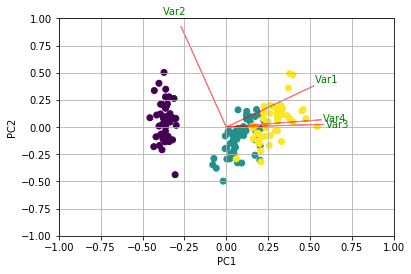

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris.data
y = iris.target
#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    


features = [x for x in range(2, 58)]
data = df.iloc[:, features]
data.fillna(0)
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)
x = nan_to_num(x)
y = list(df.loc[:, 0])
z = [0.0125 if a <= 2 else 0.025 for a in list(df.loc[:, 1])]
pca = PCA(n_components=comp_num)
principalComponents = pca.fit_transform(x)

pca = PCA()
x_new = pca.fit_transform(X)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

print(x_new[:,0:2])
print(np.transpose(pca.components_[0:2, :]))
#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()